In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import networkx as nx
import os
import plotly.express as px
from fink_utils.photometry.conversion import dc_mag
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from datetime import datetime
from scipy.optimize import curve_fit
import copy
from gatspy import periodic
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import datetime

In [2]:
random.seed(42)

In [3]:
# extract columns of interest
cols = [
    'rf_kn_vs_nonkn',
    'rf_snia_vs_nonia',
    'snn_sn_vs_all',
    'snn_snia_vs_nonia'
]


cols_in_candidate = [
    'jdstarthist',
    'magpsf',
    'sigmapsf',
    'fid', 
    'magnr', 
    'sigmagnr', 
    'isdiffpos',
    'neargaia',
    'sgscore1',
    'classtar'
]


In [4]:
liste = [
    'EB*', 'Mira', 'SN candidate', 'QSO', 'BLLac', 'Blazar',
    'RRLyr', 'YSO', 'LPV*', 'AGN','Seyfert_1', 'AGN_Candidate', 'TTau*', 'CataclyV*',
] 
#deleted 'Early SN Ia candidate', 'Microlensing candidate'

#define df as an empty dataframe
df = pd.DataFrame()

dossier = '/home/centos/data/data_march'
name = {}
count = 0
for nom_fichier in liste:
    chemin = os.path.join(dossier, "finkclass=" + nom_fichier)
    print("loading", nom_fichier, "...")

    if nom_fichier != 'CataclyV*':
        temp = pd.read_parquet([chemin + "/" + os.listdir(chemin)[i] for i in range(min(10, len(os.listdir(chemin))))])

    else:
        temp = pd.read_parquet([chemin + "/" + os.listdir(chemin)[i] for i in range(len(os.listdir(chemin)))])
        
    #add a column with the name of the file
    name[nom_fichier.split('=')[-1]] = count
    count += 1
    
    #concatenate the dataframes
    df = pd.concat([df, temp], ignore_index=True)

kilonova = pd.read_parquet('/home/centos/data/balanced_data/finkclass=Kilonova candidate')
ambiguous = pd.read_parquet('/home/centos/data/balanced_data/finkclass=Ambiguous')
SN = pd.read_parquet('/home/centos/data/balanced_data/finkclass=SN candidate')

#Add a column 'finkclass' with the value Kilonova candidate
kilonova['finkclass'] = 'Kilonova candidate'
ambiguous['finkclass'] = 'Ambiguous'
SN['finkclass'] = 'SN candidate'
df = pd.concat([df, kilonova, ambiguous, SN], ignore_index=True)


loading EB* ...


<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject


loading Mira ...
loading SN candidate ...
loading QSO ...
loading BLLac ...
loading Blazar ...
loading RRLyr ...
loading YSO ...
loading LPV* ...
loading AGN ...
loading Seyfert_1 ...
loading AGN_Candidate ...
loading TTau* ...
loading CataclyV* ...


In [5]:
variable_star_class = ['EB*', 'Mira', 'RRLyr', 'YSO', 'LPV*', "TTau*"]
AGN_class = ['QSO', 'BLLac', 'Blazar', 'AGN', 'Seyfert_1', 'AGN_Candidate']

def define_meta_class(ele):
    if ele in variable_star_class:
        ele = "Variable Star"

    elif ele in AGN_class:
        ele = "AGN"

    return ele

#for every items in df change the value of the column 'finkclass' by applying the function define_meta_class
df['finkclass'] = df['finkclass'].apply(define_meta_class)


In [6]:
#take the first 500 elements of each class
df = df.groupby('finkclass').head(200)
df = df.reset_index(drop=True)
print(df['finkclass'].value_counts())


Variable Star         200
SN candidate          200
AGN                   200
CataclyV*             200
Ambiguous             200
Kilonova candidate    183
Name: finkclass, dtype: int64


# Adding the alert ZTF23aaaatwl

In [7]:
import requests
import pandas as pd
import io
# get data for ZTF19acnjwgm
r = requests.post(
    'https://fink-portal.org/api/v1/objects',
    json={
        'objectId': 'ZTF23aaaatwl',
        'withupperlim': True,
        'output-format': 'json'
    }
)

pdf = pd.read_json(io.BytesIO(r.content))

temp = []

for col in cols:
    temp.append('d:' + col)

for col in cols_in_candidate:
    temp.append('i:' + col)

In [8]:
from fink_science.ad_features.processor import extract_features_ad_raw

def extract(pdf):
    # moment de la detection d'anomalie
    t0 = pdf[pdf['d:anomaly_score'] == np.min(pdf['d:anomaly_score'])]['i:jd'].values[0]

    # donnees 30 jours avant l'anomalie
    pdf_anomalous = pdf[(pdf['i:jd'] >= t0 - 30) & (pdf['i:jd'] <= t0)]

    if type(pdf['i:objectId']) != str:
        id = pdf['i:objectId'].values[0]

    else:
        id = pdf['i:objectId']

    features = extract_features_ad_raw(
    pdf['i:magpsf'], 
    pdf['i:jd'], 
    pdf['i:sigmapsf'], 
    pdf['i:fid'], 
    id
    )

    #create a df with every element of the dictionnary located in df['lc_features_g']
    if 1 in features:
        green = pd.DataFrame([features[1]])

    else:
        green = pd.DataFrame()

    #create a df with every element of the dictionnary located in df['lc_features_g']
    if 2 in features:
        red = pd.DataFrame([features[2]])

    else:
        red = pd.DataFrame()

    #rename every column of df_lc_features_g and df_lc_features_r by adding _g and _r after
    green = green.add_suffix('_g')
    red = red.add_suffix('_r')

    return pd.concat([green, red], axis=1)

In [9]:
to_add = pdf[temp][pdf['d:anomaly_score'] == np.min(pdf['d:anomaly_score'])]
to_add = to_add.reset_index(drop=True)

anomaly = pd.concat([to_add, extract(pdf)], axis=1)

In [10]:
r = requests.post(
  'https://fink-portal.org/api/v1/anomaly',
  json={
    'n': 10, # Optional. Number of objects to retrieve between `stop_date` and `start_date`. Default is 10.
    'start_date': "2023-06-15", # Optional. YYYY-MM-DD. Default is 2023-01-25
    'stop_date': "2023-06-27", # Optional. YYYY-MM-DD. Default is today
    'output-format': 'json'
  }
)

# Format output in a DataFrame
oids = [i['i:objectId'] for i in r.json()]

# retrieve full objects data
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': ','.join(oids),
    'output-format': 'json'
  }
)


# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

In [11]:
#create sub dataframe for every unique object_id
sous_datasets = []
for value in pdf['i:objectId'].unique():
    sous_datasets.append(pdf[pdf['i:objectId'] == value].copy())

In [12]:
for i in range(len(sous_datasets)):
  to_add = sous_datasets[i][temp][sous_datasets[i]['d:anomaly_score'] == np.min(sous_datasets[i]['d:anomaly_score'])]
  to_add = to_add.reset_index(drop=True)
  features = extract(sous_datasets[i])
  to_add = pd.concat([to_add, features], axis=1)
  anomaly = pd.concat([anomaly, to_add], axis = 0)

In [13]:
#add an index on anomaly
anomaly = anomaly.reset_index(drop=True)

In [14]:
#when a column start with a letter and then :, suppress the letter and the :
anomaly.columns = [col[2:] if col[1] == ':' else col for col in anomaly.columns]

# PCA Stuff

In [15]:
#extract columns of interest in df
df_filt = df[cols]

#create a df with the columns of interest in candidate which are located in df['candidate']
df_candidate = pd.DataFrame(df['candidate'].tolist(), columns=cols_in_candidate)

#create a df with every element of the dictionnary located in df['lc_features_g']
df_lc_features_g = pd.DataFrame(df['lc_features_g'].tolist())

#create a df with every element of the dictionnary located in df['lc_features_g']
df_lc_features_r = pd.DataFrame(df['lc_features_r'].tolist())

#rename every column of df_lc_features_g and df_lc_features_r by adding _g and _r after
df_lc_features_g = df_lc_features_g.add_suffix('_g')
df_lc_features_r = df_lc_features_r.add_suffix('_r')

#concatenate the two dataframes
df_filt = pd.concat([df_filt, df_candidate, df_lc_features_g, df_lc_features_r], axis=1)

#in the column isdiffpos, replace t by 1 and f by -1
df_filt['isdiffpos'] = df_filt['isdiffpos'].replace({'t': 1, 'f': -1})
anomaly['isdiffpos'] = anomaly['isdiffpos'].replace({'t': 1, 'f': -1})

#Normalizing data
anomaly = (anomaly - df_filt.mean()) / df_filt.std()
df_filt = (df_filt - df_filt.mean()) / df_filt.std()

#replace None or NaN by 0
anomaly = anomaly.fillna(0)
df_filt = df_filt.fillna(0)
anomaly = anomaly.reindex(columns=df_filt.columns)

label = df['finkclass']

In [16]:
#do a pca and show variance explained
n_components = 20

pca = PCA(n_components=n_components)
pca.fit(df_filt)
print(pca.explained_variance_ratio_)

[0.18771824 0.15376292 0.07184224 0.06736387 0.05131046 0.03366145
 0.03126918 0.02991438 0.0245255  0.02294296 0.02138619 0.02043592
 0.01990853 0.0194995  0.01800002 0.01664387 0.01512878 0.0145393
 0.01391751 0.01269324]


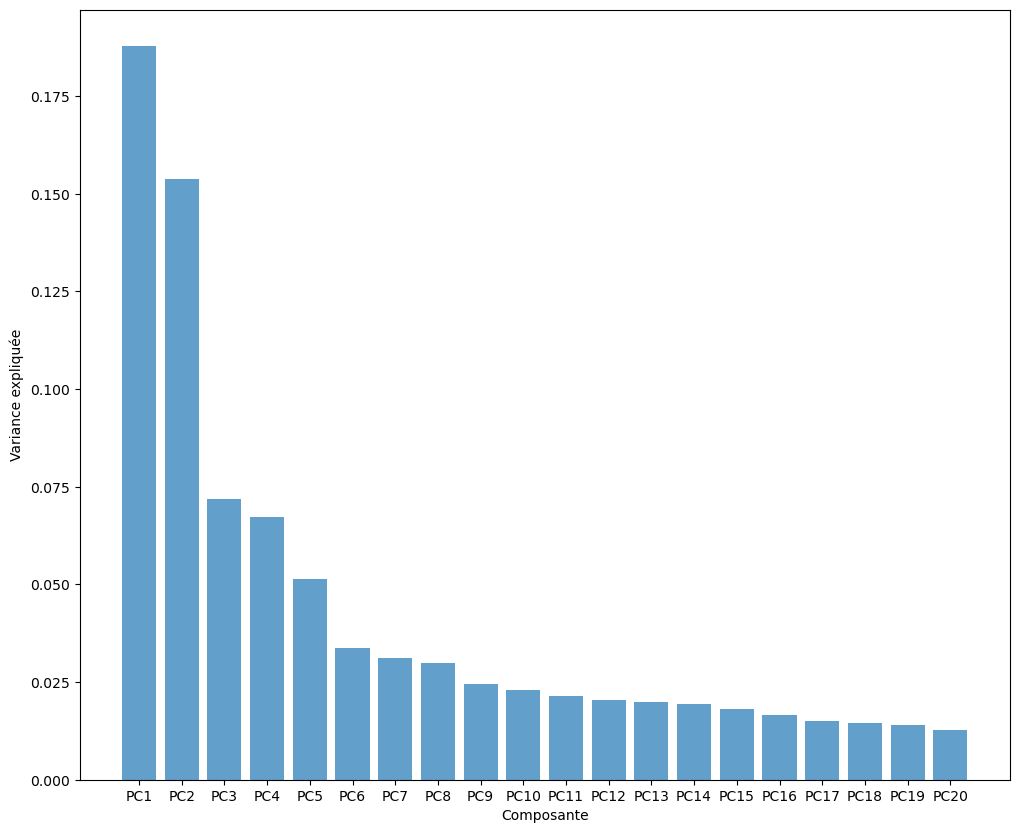

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.bar(
    ['PC{}'.format(i+1) for i in range(n_components)], 
    pca.explained_variance_ratio_,
    alpha=0.7
)

plt.xlabel("Composante")
plt.ylabel("Variance expliquée")
plt.savefig('figures/pca.png')
plt.show()
#ax.invert_yaxis()


In [18]:
#print explained variance of the first 3 components
print(sum(pca.explained_variance_ratio_[:3]))

#print explained total variance 
print(sum(pca.explained_variance_ratio_))

0.4133233991814141
0.8464640442865135


In [19]:
pca_data = pca.transform(df_filt)

anomaly_filt_selected = pca.transform(anomaly)

In [20]:
name_meta = {'Variable Star': 0,
 'AGN': 1,
 'SN candidate': 2,
 'Kilonova candidate': 3,
 'CataclyV*': 4,
 'Ambiguous': 5}

#create a list with len(name) different colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(name_meta)))

#for every key in the dictionnary name, change name[key] by colors[ind]
for ind, key in enumerate(name_meta):
    name_meta[key] = colors[ind]

tab_color = []
tab_color_str = []

for ele in df['finkclass']:
    tab_color.append(name_meta[ele])
    tab_color_str.append(ele)

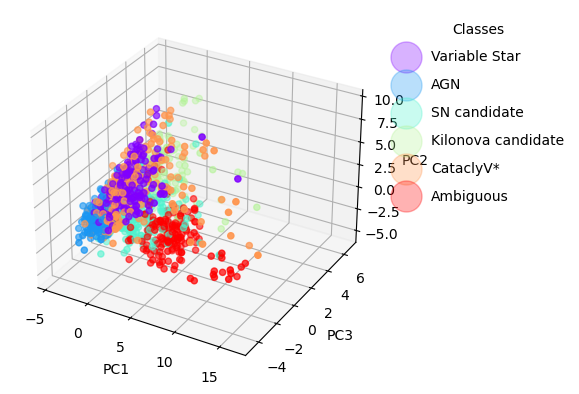

In [21]:
#plot the points in 3D with a color depending on the class on the third first components of the PCA
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:,0], pca_data[:,2], pca_data[:,1], c=tab_color)

#plot the legend where the each color is numbered 
for ind, key in enumerate(name_meta):
    ax.scatter([],[],[], color=name_meta[key], alpha=0.3, s=500, label=key)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC3')
ax.set_zlabel('PC2')

plt.show()

In [22]:
#plot the points in 3D with a color depending on the class on the third first components of the PCA
fig = px.scatter_3d(x = pca_data[:,0],  y = pca_data[:,1], z = pca_data[:,2], color=tab_color_str, labels={'color': 'Class'})

fig.update_layout(scene = dict(
                    xaxis_title='PCA 1',
                    yaxis_title='PCA 2',
                    zaxis_title='PCA 3'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show(renderer='browser')

# Using euclidian distance

In [23]:
def create_graph(lim, data, randoms, distance = np.linalg.norm):
    G = nx.Graph()
    for i in range(size):
        G.add_node(i)
        for j in range(i + 1, size):
            if distance(data[randoms[i]] - data[randoms[j]]) < lim:
                G.add_edge(i, j)
    
    return G    


def plot_graph(G, metaclass = False, title = ""):
    #rename node according to their index in the randoms
    G = nx.relabel_nodes(G, {i: randoms[i] for i in range(size)})

    plt.figure(figsize=(16,9))
    color_map = []
    #change color of each node according to their type
    if not metaclass:

        for node in G:
            color_map.append(name[df['finkclass'][node]])

        #plot the legend where the each color is numbered 
        for ind, key in enumerate(name):
            plt.scatter([],[], color=name[key], alpha=0.3, s=500, label=key)


    else:
        for node in G: 
            ele = name_meta[define_meta_class(df['finkclass'][node])]
            color_map.append(ele)

        for ind, key in enumerate(name_meta):
            plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)
    
    
    nx.draw_networkx(G, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)

    #plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(title)

    if title != "":
        plt.savefig('figures/' + title + '.png')
        
    plt.show()

    return G

#find the number of elements in each class in the graph
def number_of_elements_in_each_class(df, randoms = [], meta = False):
    if randoms == []:
        randoms = np.linspace(0, len(df) - 1, len(df))

    res = {}
    if not meta:
        for i in randoms:
            i = int(i)
            if df['finkclass'][i] in res:
                res[df['finkclass'][i]] += 1
            else:
                res[df['finkclass'][i]] = 1
    
    else:
        for i in randoms:
            i = int(i)
            ele = define_meta_class(df['finkclass'][i])
            if ele in res:
                res[ele] += 1
            else:
                res[ele] = 1
    return res

#for each edges, add one to count if it's between two different classes
def number_of_edges_between_different_classes(G, df, meta = False, alea = True, printing = True):
    count = 0

    if alea:
        G = nx.relabel_nodes(G, {i: randoms[i] for i in range(size)})

    if not meta:
        for edge in G.edges():
            if df['finkclass'][edge[0]] != df['finkclass'][edge[1]]:
                count += 1
    
    else:
        for edge in G.edges():
            if define_meta_class(df['finkclass'][edge[0]]) != define_meta_class(df['finkclass'][edge[1]]):
                count += 1
    if printing:
        print("Percentage of edges between different classes:", np.round(count/len(G.edges())*100, 2), "%")

    return count/len(G.edges())*100

#for each edges, add one to count if it's between same classes
def number_of_edges_between_same_classes(G, df, theorical, meta = False, alea = True, printing = True):
    
    count = 0

    if alea:
        G = nx.relabel_nodes(G, {i: randoms[i] for i in range(size)})

    if not meta:
        for edge in G.edges():
            if df['finkclass'][edge[0]] == df['finkclass'][edge[1]]:
                count += 1

    else:
        for edge in G.edges():
            if define_meta_class(df['finkclass'][edge[0]]) == define_meta_class(df['finkclass'][edge[1]]):
                count += 1
    
    #Assuming that we want a graph where two nodes are connected iff they are in the same class
    if printing:
        print("Percentage of edges between same classes over number of theorical edges:", np.round(count/theorical*100, 2), "%")
    
    return count/theorical*100

#for a graph, count the number of connected components
def number_of_connected_components(G):
    print("Number of connected components:", len(list(nx.connected_components(G))), "Number of isolated nodes:", len(list(nx.isolates(G))))

In [56]:
#take randomly 100 elements in pca_data
size = 100
randoms = np.random.choice(len(pca_data), size, replace=False)

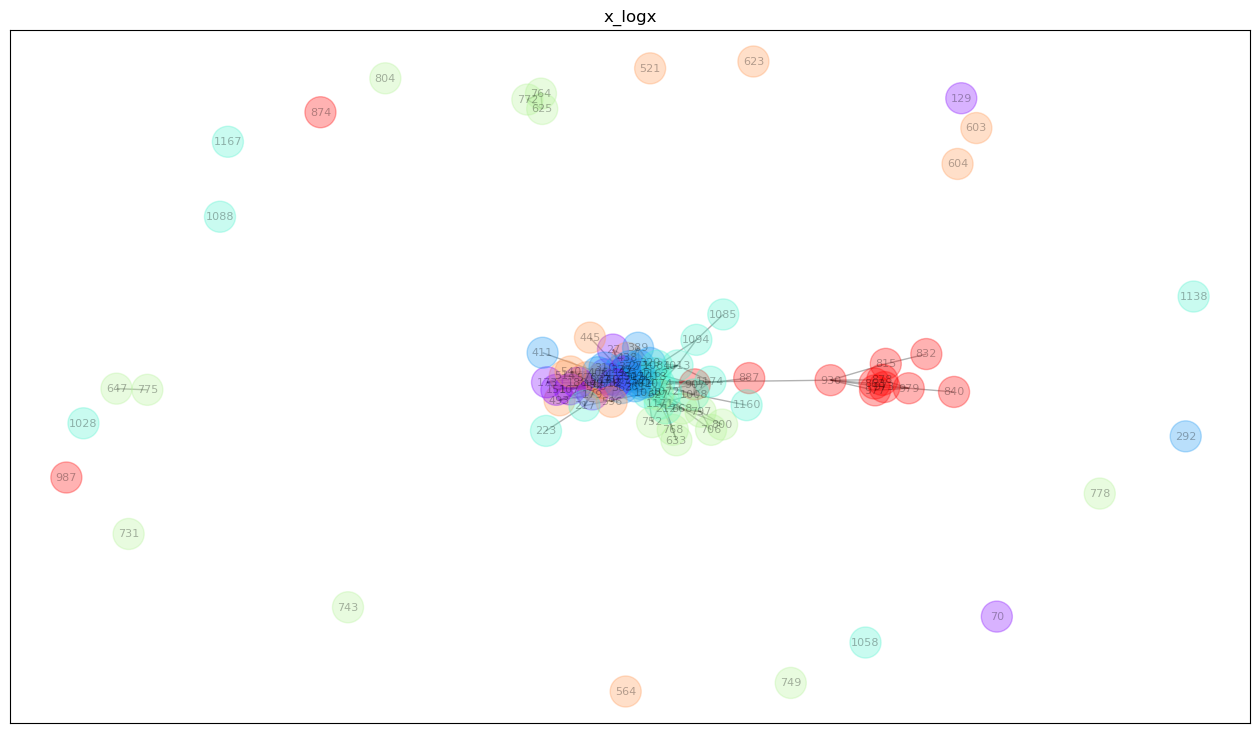

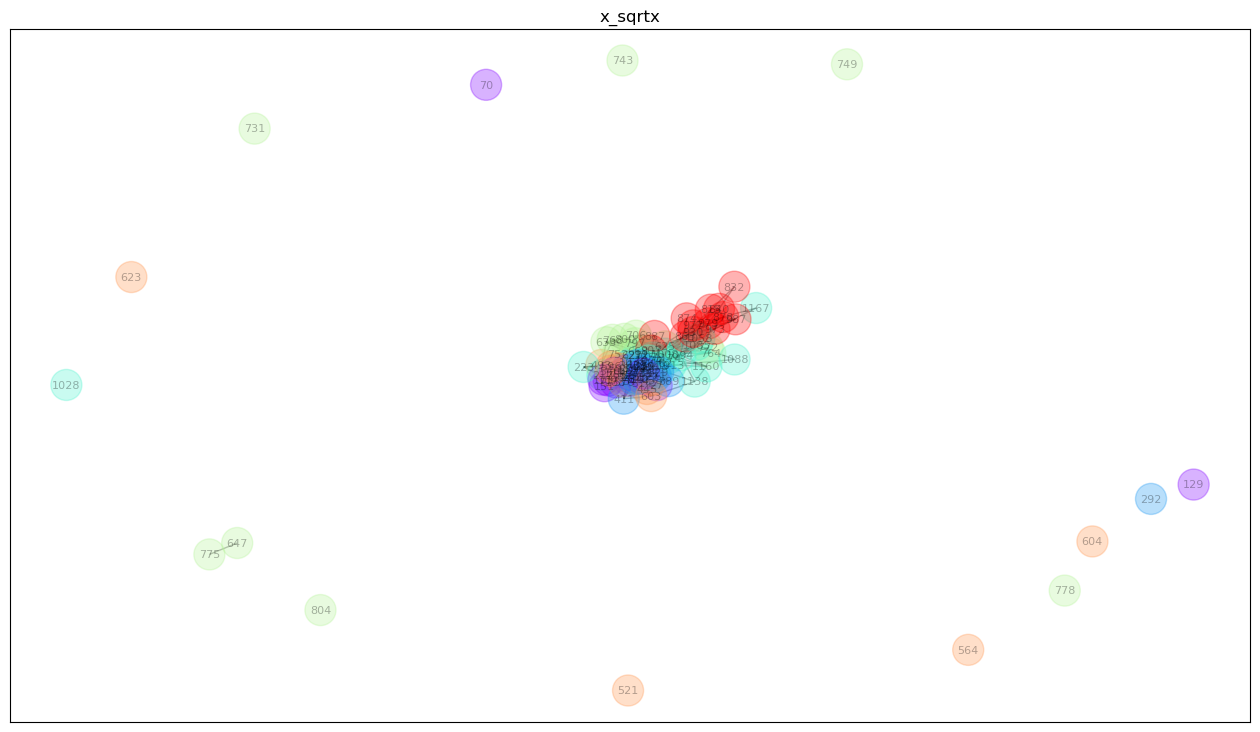

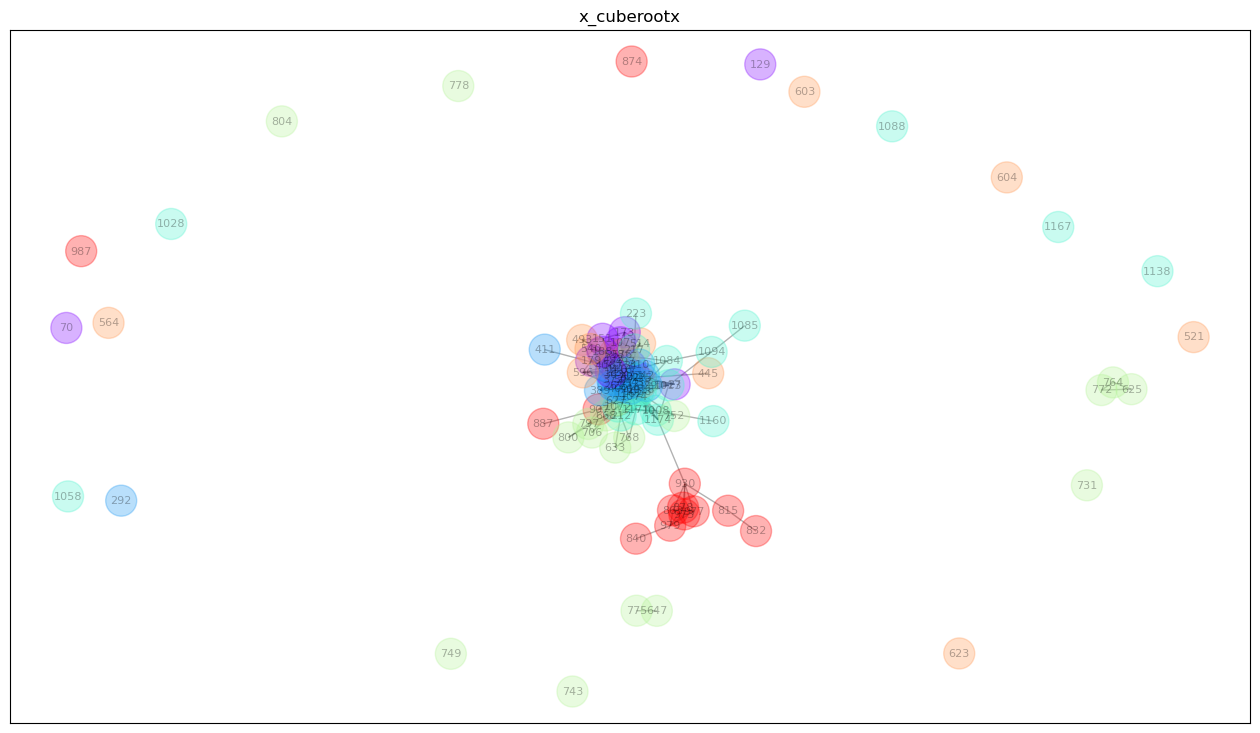

In [57]:
#function penalization
def x_logx(x):
    return x*np.log(x)

def x_sqrtx(x):
    return x*np.sqrt(x)

def x_cuberootx(x):
    return x**(4/3)


functions = [x_logx, x_sqrtx, x_cuberootx]

printing = False

res_pca = {}

for f in functions:
    
    G = nx.Graph()
    n_edges = f(size)

    new_lim = 2
    step = 1
    k = 1

    printing = False
    
    while np.abs(len(G.edges()) - n_edges)/n_edges > 0.05:
        lim = new_lim
        G = create_graph(lim, pca_data, randoms)

        if len(G.edges()) > n_edges:
            new_lim -= step/k

        else:
            new_lim += step/k

        if printing:
            print("n_egdes:", len(G.edges()), "theorical:", n_edges)
            print("Limite:", np.round(lim, 2), "Difference", np.round(len(G.edges()) - n_edges)/n_edges, 2)
        k += 1

    G = plot_graph(G, metaclass = True, title = f.__name__)

    res_pca[f.__name__] = G

In [58]:
for key, G in res_pca.items():
    print(key)

x_logx
x_sqrtx
x_cuberootx


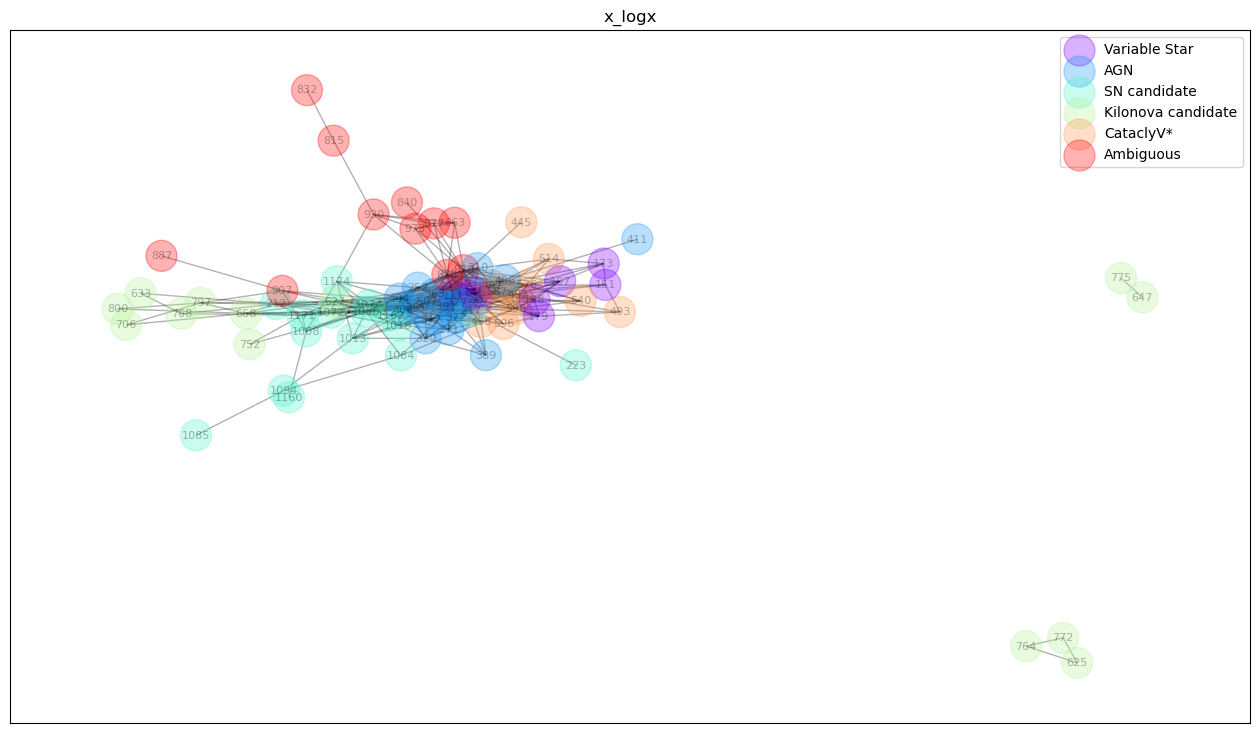

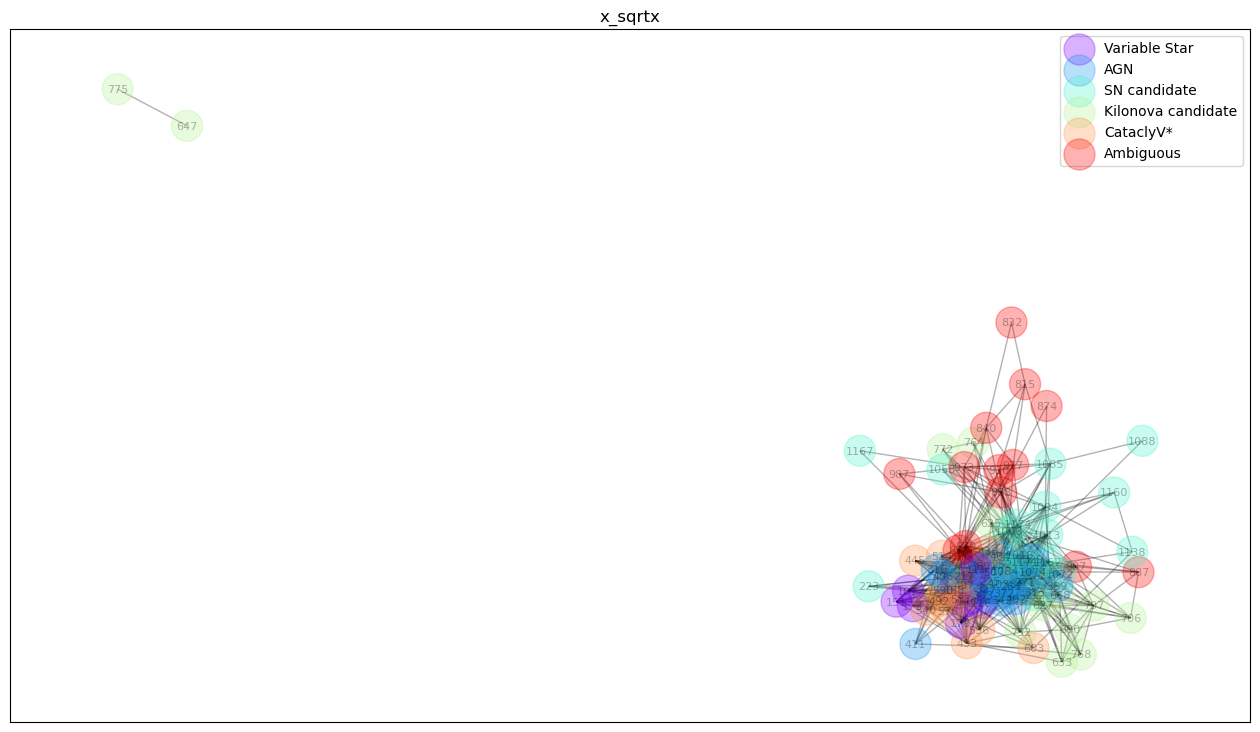

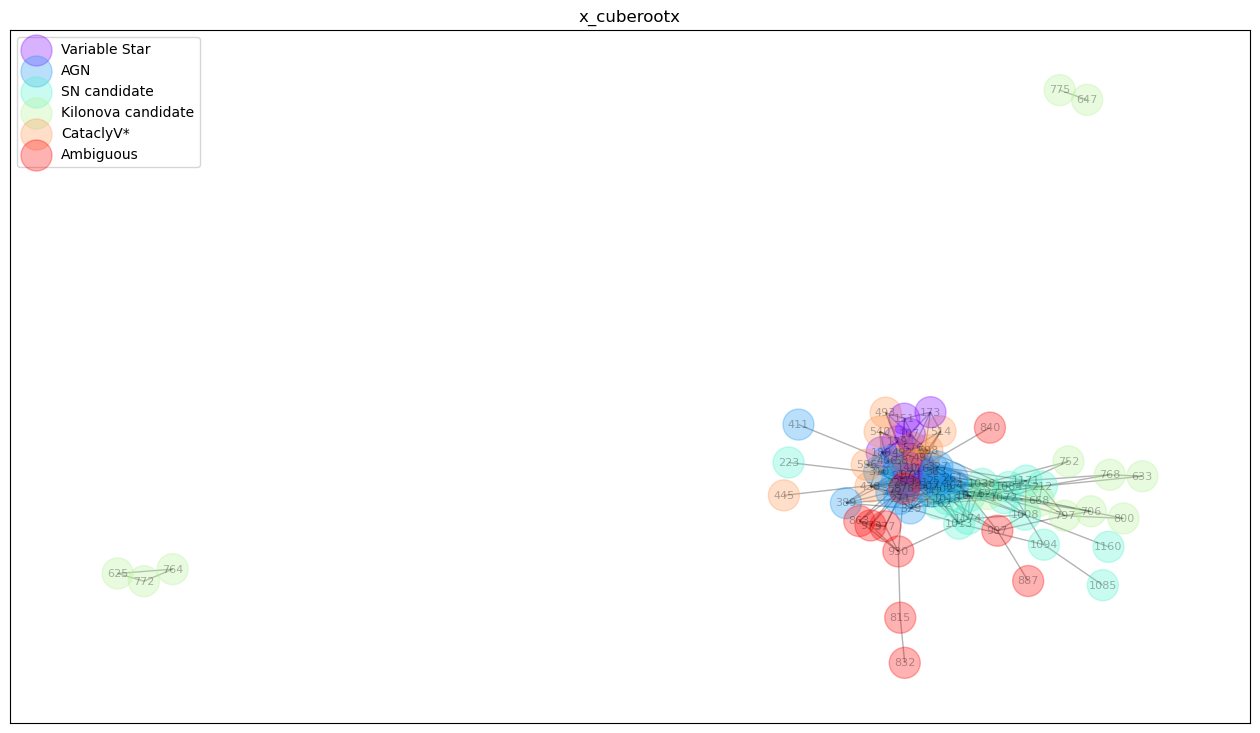

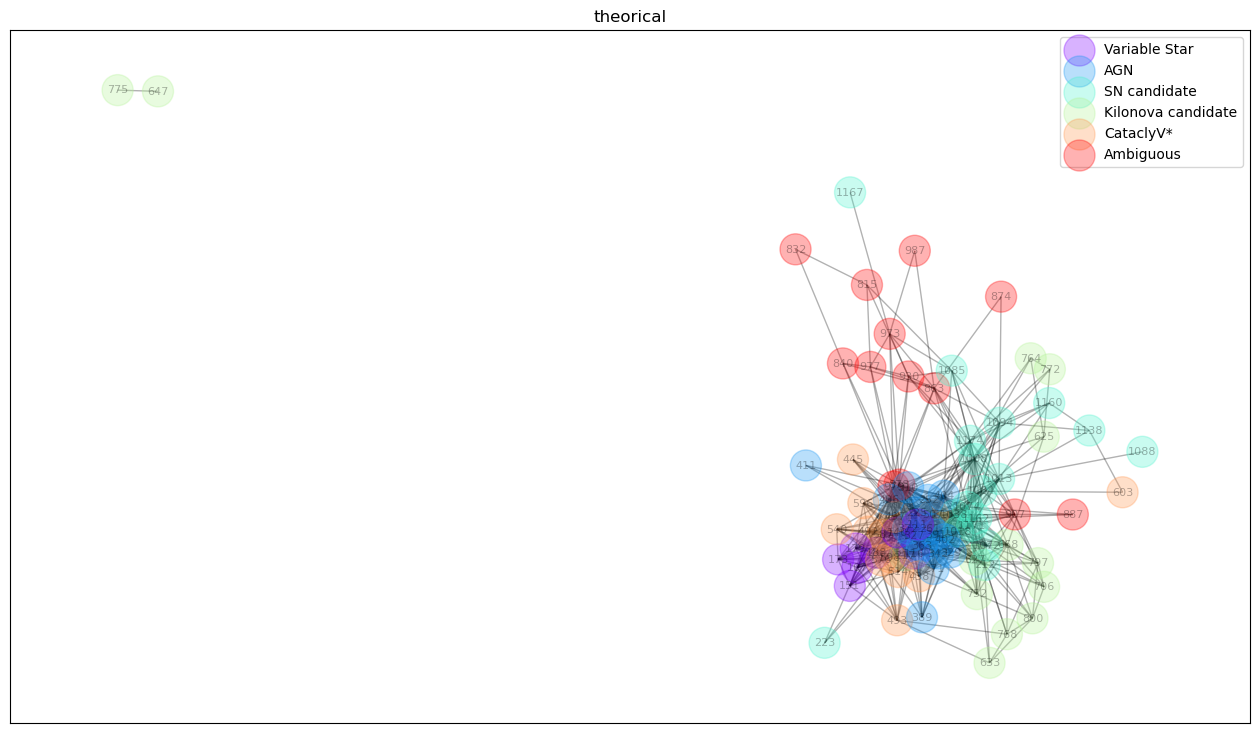

In [69]:
for key, G in res_pca.items():
    G = nx.relabel_nodes(G, {i: randoms[i] for i in range(size)})

    G_plot = nx.Graph()
    plt.figure(figsize=(16,9))
    color_map = []

    for node in G:
        if len(G.edges(node)) > 0:
            if node not in [647, 775]:

                ele = name_meta[define_meta_class(df['finkclass'][node])]
                color_map.append(ele)
                G_plot.add_node(node)

    for node in G:
        if len(G.edges(node)) > 0:
            if node not in [647, 775]:                
                #add the edges between the node and the nodes connected to it
                for edge in G.edges(node):
                    if edge[1] == node:
                        G_plot.add_edge(node, edge[0])
                        
                    else:
                        G_plot.add_edge(node, edge[1])

    for ind, key1 in enumerate(name_meta):
        plt.scatter([],[], color=name_meta[key1], alpha=0.3, s=500, label=key1)
    
    
    nx.draw_networkx(G_plot, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)
    #plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
    
    plt.title(key)
    plt.legend()
    plt.savefig('figures/' + key + '_graph_wo_alone.png')
        
    plt.show()

In [27]:
#connected components penalization
G = nx.Graph()

new_lim = 5
step = 0.01
count = 0

printing = False

while len(list(nx.connected_components(G))) != 1:
    lim = new_lim
    G = create_graph(lim, pca_data, randoms)

    new_lim += step

    if count % 50 == 0 and printing:
        print("Limite:", np.round(lim, 2), "Number of connected components", len(list(nx.connected_components(G))))

    count += 1

plot_graph(G, metaclass = True, title = "one_component")
res_pca['one_connected_component'] = G

KeyboardInterrupt: 

In [47]:
tab_ele = number_of_elements_in_each_class(df, randoms= randoms, meta = True)
tab_ele

/tmp/ipykernel_2839/1429892890.py:52: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



{'Ambiguous': 18,
 'SN candidate': 15,
 'AGN': 17,
 'Variable Star': 14,
 'Kilonova candidate': 18,
 'CataclyV*': 18}

In [48]:
theorical = 0

for key, ind in tab_ele.items():
    theorical += int(ind*(ind-1)/2)

theorical

791

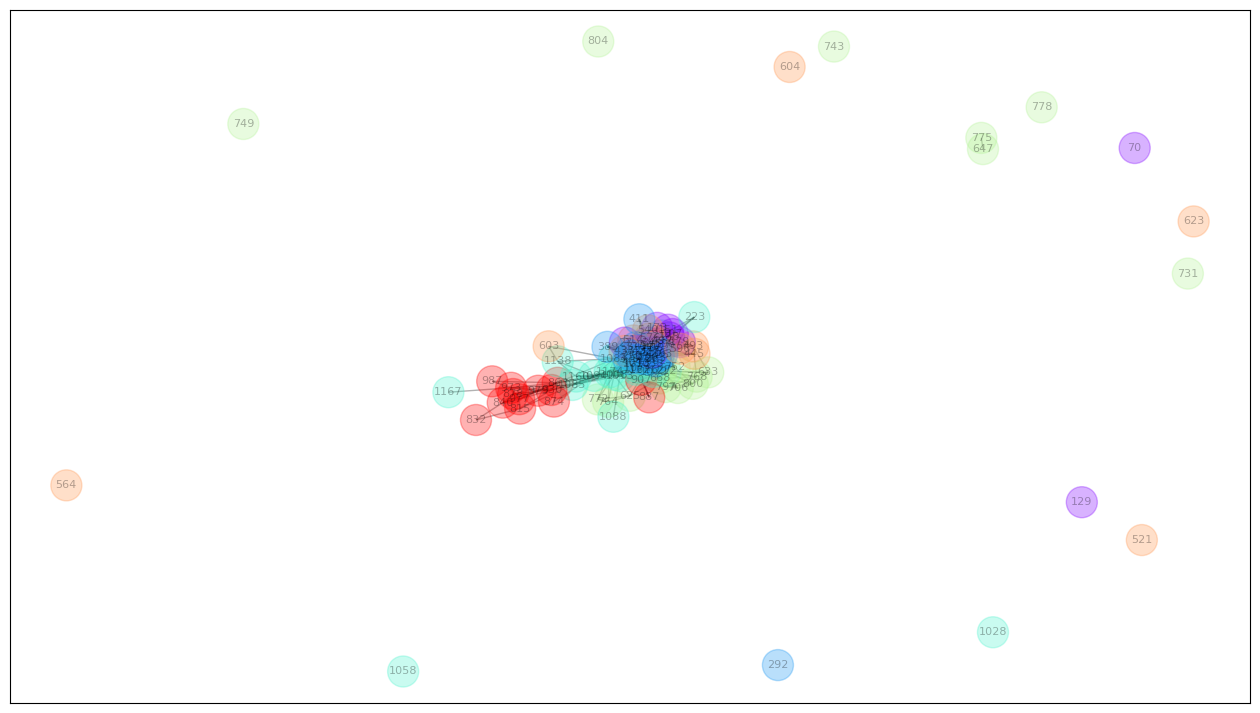

In [64]:
#With the number of theorical links

G = nx.Graph()
n_edges = f(size)

new_lim = 2
step = 0.01
k = 1
printing = False

while np.abs(len(G.edges()) - theorical)/theorical > 0.01:
    lim = new_lim
    G = create_graph(lim, pca_data, randoms)

    new_lim += step

    if printing:
        print("n_egdes:", len(G.edges()), "theorical:", theorical)
        print("Limite:", np.round(lim, 2), "Difference", np.round(len(G.edges()) - theorical)/theorical, 2)
    k += 1

G = plot_graph(G, metaclass = True)

res_pca['theorical'] = G

In [46]:
for ind, key in enumerate(res_pca):
    print(key)
    number_of_connected_components(res_pca[key])
    number_of_edges_between_different_classes(res_pca[key], df, meta = True)
    number_of_edges_between_same_classes(res_pca[key], df, theorical, meta = True)
    #print("\n")

x_logx
Number of connected components: 21 Number of isolated nodes: 19
Percentage of edges between different classes: 58.03 %
Percentage of edges between same classes over number of theorical edges: 22.62 %
x_sqrtx
Number of connected components: 11 Number of isolated nodes: 9
Percentage of edges between different classes: 68.34 %
Percentage of edges between same classes over number of theorical edges: 35.97 %
x_cuberootx
Number of connected components: 20 Number of isolated nodes: 17
Percentage of edges between different classes: 59.02 %
Percentage of edges between same classes over number of theorical edges: 23.86 %
one_connected_component
Number of connected components: 1 Number of isolated nodes: 0
Percentage of edges between different classes: 82.75 %
Percentage of edges between same classes over number of theorical edges: 94.31 %
theorical
Number of connected components: 12 Number of isolated nodes: 9
Percentage of edges between different classes: 66.67 %
Percentage of edges betw

# Neural network

In [18]:
#convert pca_data to dataframe
pca_data = pd.DataFrame(pca_data)
anomaly_filt_selected = pd.DataFrame(anomaly_filt_selected)


NameError: name 'anomaly_filt_selected' is not defined

In [19]:
#find the index of "ambiguous" in df
ind_ambiguous = df[df['finkclass'] == 'Ambiguous'].index

#remove the index of ambiguous in pca_data
pca_data = pca_data.drop(ind_ambiguous)

In [20]:
df_filt_selected_sample = pca_data.sample(n = 200, random_state=42)
label_sample = label[df_filt_selected_sample.index]

#create an other sample with 100 different elements of df_filt_selected and label
df_filt_selected_sample2 = pca_data.drop(df_filt_selected_sample.index)
df_filt_selected_sample2 = df_filt_selected_sample2.sample(n = 100, random_state=42)
label_sample2 = label[df_filt_selected_sample2.index]


In [22]:
#print index df_filt_selected_sample and compare it to df_filt_selected_sample2
for i in range(len(df_filt_selected_sample.index)):
    if df_filt_selected_sample.index[i] in df_filt_selected_sample2.index:
        print("Error")

print("done")


done


In [23]:
#creating a X_train containing all pair of X_train
X_train = []
y_train = []
for i in range(len(df_filt_selected_sample)):
    for j in range(i+1, len(df_filt_selected_sample)):
        X_train.append([df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()])
        y_train.append(1 if label_sample.iloc[i] == label_sample.iloc[j] else 0)

X_test = []
y_test = []
for i in range(len(df_filt_selected_sample2)):
    for j in range(i+1, len(df_filt_selected_sample2)):
        X_test.append([df_filt_selected_sample2.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()])
        y_test.append(1 if label_sample2.iloc[i] == label_sample2.iloc[j] else 0)

In [24]:
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    def __len__(self):
        return self.length

trainset = dataset(X_train, y_train)
#DataLoader
trainloader = DataLoader(trainset, batch_size=64, shuffle=False)

testset = dataset(X_test, y_test)
#DataLoader
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [25]:
#create a neural network that take a element of X_train with size (2, 22) and predict the labels with a fc layer with 22 neurons

class Net(nn.Module):
    def __init__(self, nb_variables):
        super(Net, self).__init__()
        self.nb_variables = nb_variables
        self.stack = nn.Sequential(nn.Linear(2*nb_variables, 4*nb_variables),
        nn.ReLU(),
        nn.Linear(4*nb_variables, 2*nb_variables),
        nn.ReLU(),
        nn.Linear(2*nb_variables, 1),
        nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 2*self.nb_variables)
        x = self.stack(x)

        return x

net = Net(20)

#print the archetecture of the neural network
print(net)

#print the number of parameters
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

Net(
  (stack): Sequential(
    (0): Linear(in_features=40, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
6561


In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred[:,0], y)

        # Backpropagation (always in three steps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch %1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred[:,0], y).item()
            pred = torch.tensor([1 if pred[i] > 0.5 else 0 for i in range(len(pred))])
            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return 100*(1-correct)

In [27]:
# Hyperparameters
learning_rate = 0.001
epochs = 200
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

In [107]:
error = []

for t in range(epochs):
    print(f"Epoch {t+1}-----------------")
    # Use train_loop and test_loop functions
    train_loop(trainloader, net, loss_fn, optimizer)
    x = test_loop(testloader, net, loss_fn)
    error.append(x)
print("Done!")

Epoch 1-----------------
loss: 0.757682  [    0/19900]
Test Error: 
 Accuracy: 80.4%, Avg loss: 0.402538
Epoch 2-----------------
loss: 0.374455  [    0/19900]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.348065
Epoch 3-----------------
loss: 0.192586  [    0/19900]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.331651
Epoch 4-----------------
loss: 0.163272  [    0/19900]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.335548
Epoch 5-----------------
loss: 0.140038  [    0/19900]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.310940
Epoch 6-----------------
loss: 0.128966  [    0/19900]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.317371
Epoch 7-----------------
loss: 0.128743  [    0/19900]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.315124
Epoch 8-----------------
loss: 0.134781  [    0/19900]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.318132
Epoch 9-----------------
loss: 0.111145  [    0/19900]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.320818
Epoch 10-----------------
loss: 0.088331  [    0/19900]

KeyboardInterrupt: 

: 

In [28]:
checkpoint = torch.load('results/models/pca model.pt')
net.load_state_dict(checkpoint)
error = list(np.loadtxt('results/models/pca model.csv', delimiter=','))

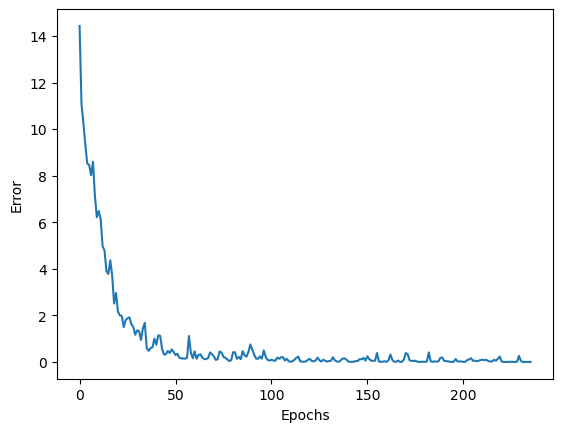

In [29]:
plt.plot(error)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [30]:
#take randomly 20 elements in the df ambiguous
ambiguous_sample = ambiguous.sample(20, random_state=42)

In [32]:
#defining the graph
G = nx.Graph()
#set anomaly as an empty df
anomaly = pd.DataFrame()

#defining colors
color_map = []
thresh = 0.5
#change color of each node according to their type
G.add_nodes_from(df_filt_selected_sample2.index)

for node in G: 
    ele = name_meta[df['finkclass'][node]]
    color_map.append(ele)

#add edges
dict_edges = {}
for i in range(len(df_filt_selected_sample2) + len(anomaly) + len(ambiguous_sample)):
    dict_edges[i] = {}
    
for i in range(len(df_filt_selected_sample2)):
    
    for j in range(i+1, len(df_filt_selected_sample2)):
        pred = float(net(torch.tensor([[df_filt_selected_sample2.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > thresh:
            G.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[j])
            

            dict_edges[i][j] = pred
            dict_edges[j][i] = pred

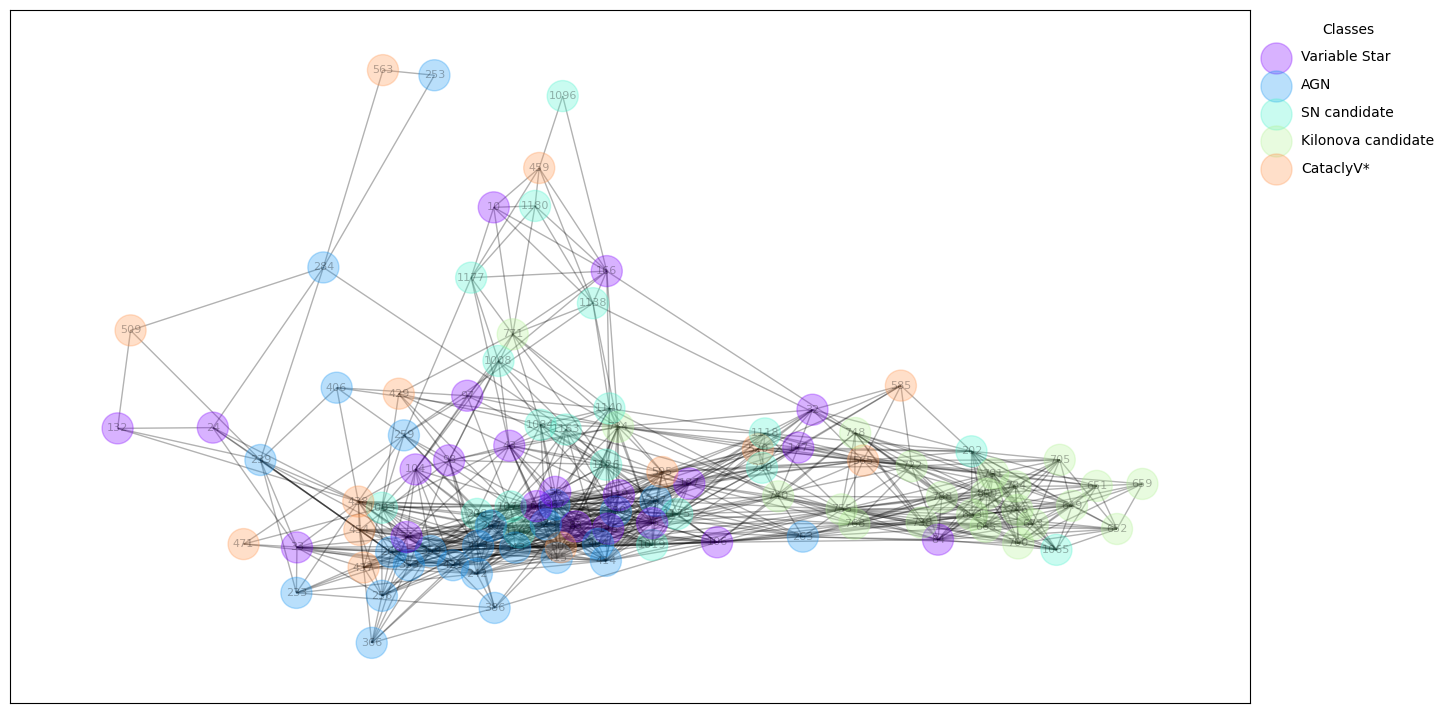

In [33]:
plt.figure(figsize=(16,9))

for ind, key in enumerate(name_meta):
    if key != 'Ambiguous':
        plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)

nx.draw_networkx(G, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [215]:
#defining the graph
G_ano = nx.Graph()

#defining colors
color_map = []
thresh = 0.5
#change color of each node according to their type
G_ano.add_nodes_from(df_filt_selected_sample2.index)

for node in G: 
    ele = name_meta[df['finkclass'][node]]
    color_map.append(ele)

#add edges
dict_edges = {}
for i in range(len(df_filt_selected_sample2) + len(anomaly) + len(ambiguous_sample)):
    dict_edges[i] = {}
    
for i in range(len(df_filt_selected_sample2)):
    
    for j in range(i+1, len(df_filt_selected_sample2)):
        pred = float(net(torch.tensor([[df_filt_selected_sample2.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > thresh:
            G_ano.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[j])
            

            dict_edges[i][j] = pred
            dict_edges[j][i] = pred

if True:
    #adding anomaly edges

    count = 0
    for i in range(len(anomaly)):
        G_ano.add_node("Ano" + str(i))
        if i == 0:
            color_map.append("gold")
        else:
            color_map.append("black")
        count_meta = {'Variable Star': 0,
                'AGN': 0,
                'SN candidate': 0,
                'Ambiguous': 0,
                'Kilonova candidate': 0}
        for j in range(len(df_filt_selected_sample2)):
            pred = float(net(torch.tensor([[anomaly_filt_selected.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))

            if pred > thresh:
                G_ano.add_edge("Ano" + str(i), df_filt_selected_sample2.index[j])
                

                dict_edges[len(df_filt_selected_sample2) + i][j] = pred
                dict_edges[j][len(df_filt_selected_sample2) + i] = pred

                count_meta[df['finkclass'][df_filt_selected_sample2.index[j]]] += 1

        for key, ind in count_meta.items():
            if ind != 0:
                print("Ano" + str(i), "is linked with", ind, key)

        count += sum(count_meta.values())

    print(count, "anomaly edges added over", int(len(df_filt_selected_sample2)**2), "possible edges ie", int((count/len(df_filt_selected_sample2)**2)*100), "%")

    count = 0
    taille = len(df_filt_selected_sample2)    
    for i in range(len(anomaly)):
        for j in range(i + 1, len(anomaly)):

            pred = float(net(torch.tensor([[anomaly_filt_selected.iloc[i].to_list(), anomaly_filt_selected.iloc[j].to_list()]], dtype=torch.float32)))

            if pred > thresh:
                G_ano.add_edge("Ano" + str(i), "Ano" + str(j))
                

                dict_edges[taille + i][taille + j] = pred
                dict_edges[taille + j][taille + i] = pred
                count += 1
                print("Ano" + str(i), "Ano" + str(j), "are linked !")

    
    print(count, "anomaly edges added over", int(len(anomaly) * (len(anomaly) - 1) / 2), "possible edges ie", int((count/(len(anomaly) * (len(anomaly) - 1) / 2)*100)), "%")

    #adding ambiguous edges
    G_ano.add_nodes_from(ambiguous_sample.index)
    for i in range(len(ambiguous_sample)):
        color_map.append(name_meta["Ambiguous"])
        for j in range(i + 1, len(anomaly)):
            pred = float(net(torch.tensor([[ambiguous_sample.iloc[i].to_list(), anomaly_filt_selected.iloc[j].to_list()]], dtype=torch.float32)))
            if pred > thresh:
                G_ano.add_edge(ambiguous_sample.index[i], anomaly.index[j])
                

                dict_edges[taille + len(anomaly) + i][taille + j] = pred
                dict_edges[taille + j][taille + len(anomaly) + i] = pred

    taille = len(df_filt_selected_sample2) + len(anomaly)

    for i in range(len(ambiguous_sample)):
        for j in range(len(df_filt_selected_sample2)):
            pred = float(net(torch.tensor([[ambiguous_sample.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
            if pred > thresh:
                G_ano.add_edge(ambiguous_sample.index[i], df_filt_selected_sample2.index[j])
                

                dict_edges[taille + i][j] = pred
                dict_edges[j][taille + i] = pred

    for i in range(len(ambiguous_sample)):
        for j in range(i + 1, len(ambiguous_sample)):
            pred = float(net(torch.tensor([[ambiguous_sample.iloc[i].to_list(), ambiguous_sample.iloc[j].to_list()]], dtype=torch.float32)))
            if pred > thresh:
                G_ano.add_edge(ambiguous_sample.index[i], ambiguous_sample.index[j])
                

                dict_edges[taille + i][taille + j] = pred
                dict_edges[taille + j][taille + i] = pred
    
    

    #filtering the nodes without edges
    nodes_with_edges = []
    filtered_color = []
    i = 0

    at_least_one = False
    for node in G_ano.nodes():
        at_least_one = False
        if len(G_ano.edges(node)) > 0:
            nodes_with_edges.append(node)
            filtered_color.append(color_map[i])
            at_least_one = True

        if not at_least_one:
            print(node, "has no edges")
        

        i += 1

0 anomaly edges added over 40000 possible edges ie 0 %
Ano0 Ano1 are linked !
Ano0 Ano2 are linked !
Ano0 Ano3 are linked !
Ano0 Ano4 are linked !
Ano0 Ano5 are linked !
Ano0 Ano6 are linked !
Ano0 Ano7 are linked !
Ano0 Ano9 are linked !
Ano0 Ano10 are linked !
Ano1 Ano2 are linked !
Ano1 Ano3 are linked !
Ano1 Ano4 are linked !
Ano1 Ano5 are linked !
Ano1 Ano6 are linked !
Ano1 Ano7 are linked !
Ano1 Ano9 are linked !
Ano1 Ano10 are linked !
Ano2 Ano3 are linked !
Ano2 Ano4 are linked !
Ano2 Ano5 are linked !
Ano2 Ano6 are linked !
Ano2 Ano7 are linked !
Ano2 Ano9 are linked !
Ano2 Ano10 are linked !
Ano3 Ano4 are linked !
Ano3 Ano5 are linked !
Ano3 Ano6 are linked !
Ano3 Ano7 are linked !
Ano3 Ano9 are linked !
Ano3 Ano10 are linked !
Ano4 Ano5 are linked !
Ano4 Ano6 are linked !
Ano4 Ano7 are linked !
Ano4 Ano9 are linked !
Ano4 Ano10 are linked !
Ano5 Ano6 are linked !
Ano5 Ano7 are linked !
Ano5 Ano9 are linked !
Ano5 Ano10 are linked !
Ano6 Ano7 are linked !
Ano6 Ano9 are linke

/home/centos/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



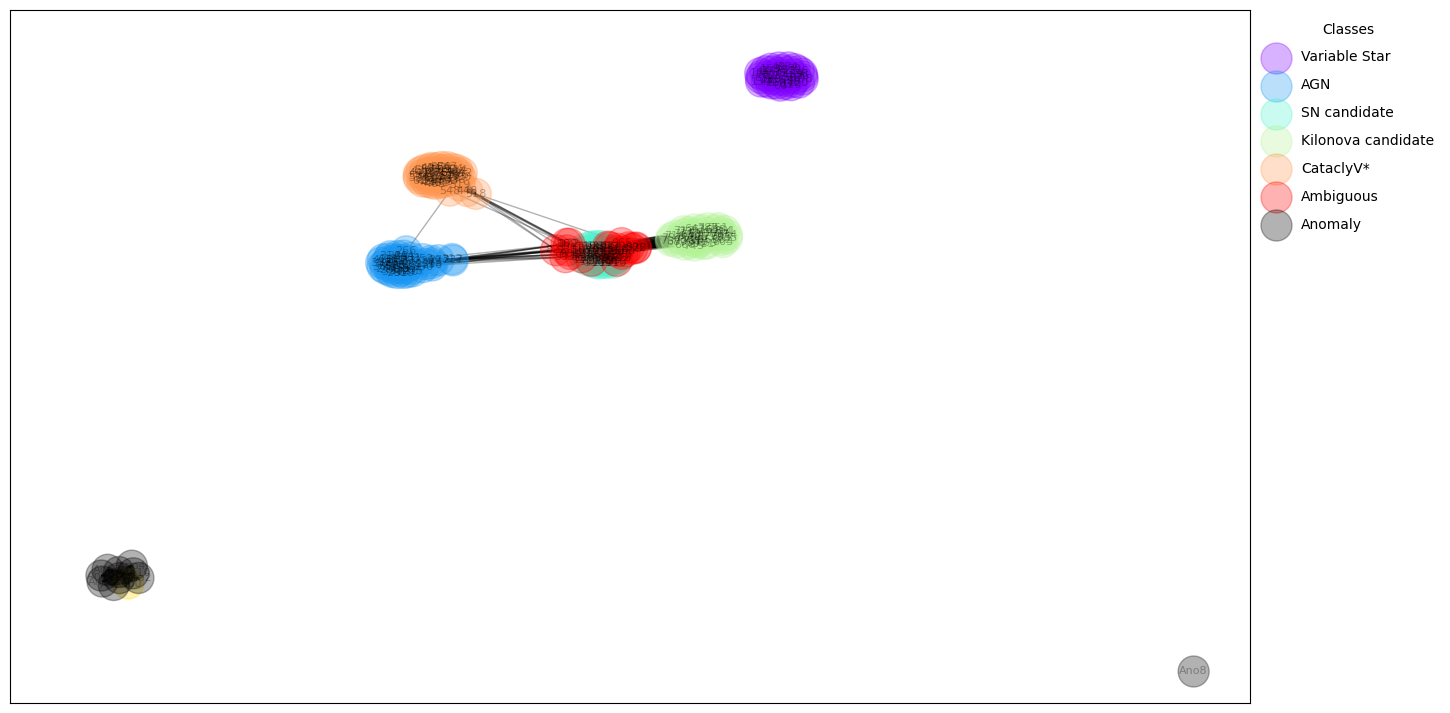

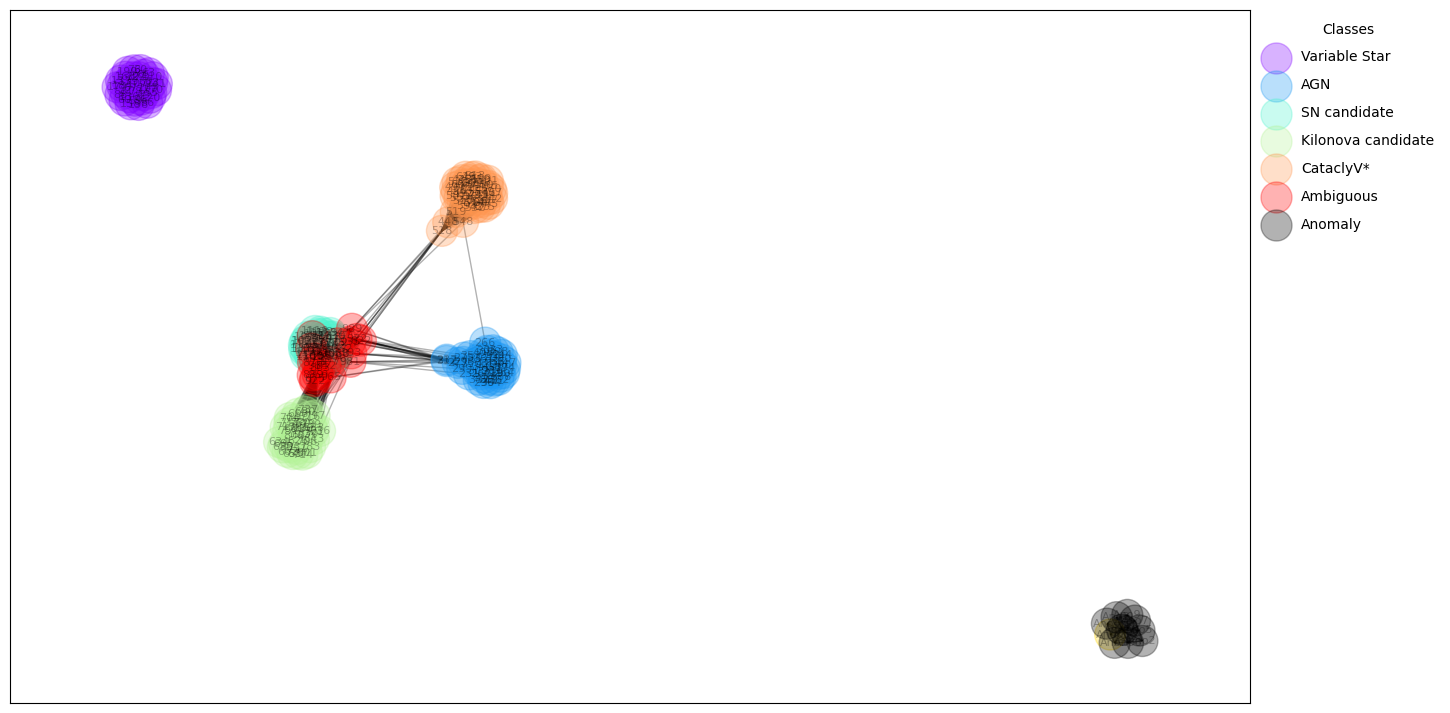

In [216]:
plt.figure(figsize=(16,9))

for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)

plt.scatter([],[], color="black", alpha=0.3, s=500, label="Anomaly")

nx.draw_networkx(G_ano, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

plt.figure(figsize=(16,9))

for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)

plt.scatter([],[], color="black", alpha=0.3, s=500, label="Anomaly")
    
nx.draw_networkx(G_ano, with_labels=True, nodelist = nodes_with_edges, node_color=filtered_color, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()